Text To Img

In [ ]:
pip install pycocotools


In [ ]:

!pip install openai==0.28


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import requests
from io import BytesIO
from pycocotools.coco import COCO
from torch.utils.data import DataLoader, TensorDataset

# CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# COCO annotations JSON dosyası
coco_caps = COCO('/content/drive/MyDrive/captions_train2017.json')

loading annotations into memory...
Done (t=5.20s)
creating index...
index created!


In [ ]:

# Görüntüleri ve açıklamaları depolamak için boş listeler
image_list = []
caption_list = []

# Tüm görüntü ID'lerini alın ve veri setini küçültme işlemi
img_ids = coco_caps.getImgIds()[:500]

for img_id in img_ids:
    ann_ids = coco_caps.getAnnIds(imgIds=img_id)
    anns = coco_caps.loadAnns(ann_ids)
    caption = anns[0]['caption']
    img_info = coco_caps.loadImgs(img_id)[0]
    img_url = img_info['coco_url']

    # Görüntüyü indirme dönüştür
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    img = transform(img)

    image_list.append(img)
    caption_list.append(caption)

# Embedding boyutu
unique_captions = list(set(caption_list))
caption_to_idx = {caption: idx for idx, caption in enumerate(unique_captions)}
caption_list = [caption_to_idx[caption] for caption in caption_list]

In [ ]:

# Listeleri tensora dönüştür ve CUDA'ya taşıma
images = torch.stack(image_list).to(device)
captions = torch.tensor(caption_list).to(device)

# Dataset ve DataLoader oluşturma
dataset = TensorDataset(images, captions)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# GAN modeli
class Generator(nn.Module):
    def __init__(self, latent_dim, caption_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.label_emb = nn.Embedding(caption_dim, caption_dim)

        self.model = nn.Sequential(
            nn.Linear(latent_dim + caption_dim, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, int(torch.prod(torch.tensor(self.img_shape)))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self, caption_dim, img_shape):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(caption_dim, caption_dim)

        self.model = nn.Sequential(
            nn.Linear(caption_dim + int(torch.prod(torch.tensor(img_shape))), 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

# Parametreler
latent_dim = 100
caption_dim = len(unique_captions)
img_shape = (3, 64, 64)
epochs = 2000
learning_rate = 0.0002

# Model oluşturma
generator = Generator(latent_dim, caption_dim, img_shape).to(device)
discriminator = Discriminator(caption_dim, img_shape).to(device)

# Optimizatörler
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss fonksiyonu
adversarial_loss = torch.nn.BCELoss().to(device)


In [ ]:
# Model eğitimi
for epoch in range(epochs):
    for batch_imgs, batch_labels in dataloader:
        batch_imgs = batch_imgs.to(device)
        batch_labels = batch_labels.to(device)

        # Gerçekler
        valid = torch.ones((batch_imgs.size(0), 1)).to(device)
        fake = torch.zeros((batch_imgs.size(0), 1)).to(device)

        # Rastgele gürültü vektörleri
        z = torch.randn((batch_imgs.size(0), latent_dim)).to(device)

        # Görüntü üretme
        gen_imgs = generator(z, batch_labels)

        # Discriminator'ı eğitme
        real_loss = adversarial_loss(discriminator(batch_imgs, batch_labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), batch_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Generator'ı eğitme
        g_loss = adversarial_loss(discriminator(gen_imgs, batch_labels), valid)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch}/{epochs} - D loss: {d_loss.item()} - G loss: {g_loss.item()}")

    # Modeli ve örnek görüntüleri kaydet
    if epoch % 500 == 0:
        torch.save(generator.state_dict(), f"generator_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"discriminator_{epoch}.pth")

        # Ara ara örnek görüntüler oluşturup kaydetme
        sample_image = generator(z[:5], batch_labels[:5]).data
        save_image(sample_image, f"generated_{epoch}.png", nrow=5, normalize=True)

Epoch 0/2000 - D loss: 0.2832145690917969 - G loss: 0.9503973722457886
Epoch 1/2000 - D loss: 0.19861994683742523 - G loss: 1.2952214479446411
Epoch 2/2000 - D loss: 0.329464852809906 - G loss: 0.8879854679107666
Epoch 3/2000 - D loss: 0.2815786302089691 - G loss: 1.0432237386703491
Epoch 4/2000 - D loss: 0.3086372911930084 - G loss: 1.007453203201294
Epoch 5/2000 - D loss: 0.1968536227941513 - G loss: 1.4337607622146606
Epoch 6/2000 - D loss: 0.18958139419555664 - G loss: 1.5480399131774902
Epoch 7/2000 - D loss: 0.11403564363718033 - G loss: 2.0496175289154053
Epoch 8/2000 - D loss: 0.1827930361032486 - G loss: 1.6062915325164795
Epoch 9/2000 - D loss: 0.09437476843595505 - G loss: 2.2374157905578613
Epoch 10/2000 - D loss: 0.09453096240758896 - G loss: 2.224783182144165
Epoch 11/2000 - D loss: 0.07775942981243134 - G loss: 2.6271378993988037
Epoch 12/2000 - D loss: 0.0662650316953659 - G loss: 2.859595775604248
Epoch 13/2000 - D loss: 0.04729294031858444 - G loss: 3.110675573348999


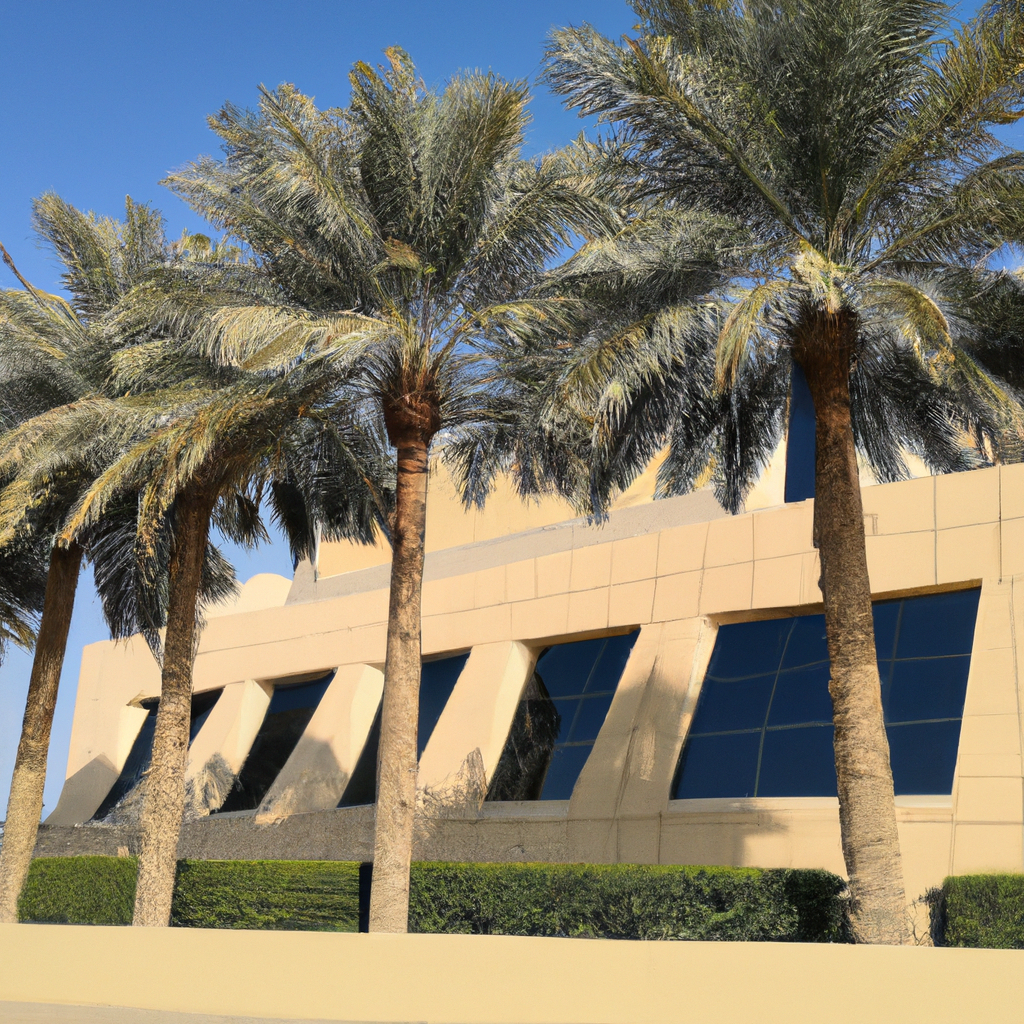

In [ ]:
import openai
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display

# API anahtarı
openai.api_key = 's*********************************************************************A'

# Metin girdisini ayarlayın
response = openai.Image.create(
    prompt="a med school in  Arabia",  #metin
    n=1,  # Üretilecek görüntü sayısı
    size="1024x1024"  # Görüntü boyutu
)

image_url = response['data'][0]['url']

response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

img.save("generated_image_dalle.png")
display(img)
